In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [3]:
import cfdnetplus

In [4]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_mse_adam_p'

In [4]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [5]:

df = np.empty((0,66,256,7))
df_label = np.empty((0,66,256,7))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(2295, 66, 256, 7)


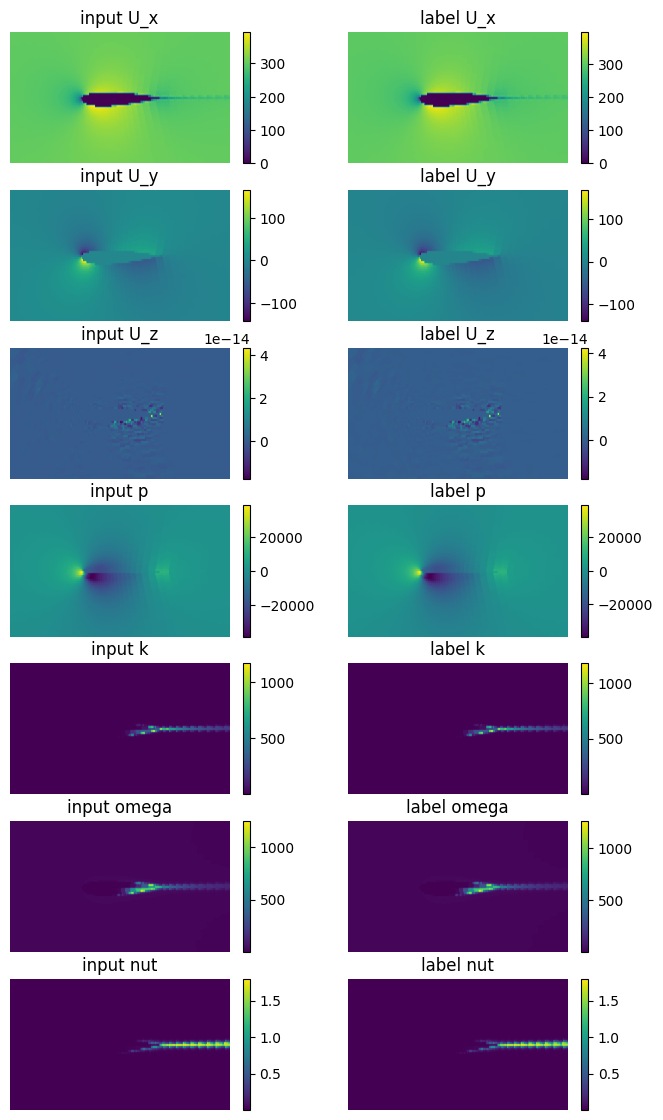

In [6]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

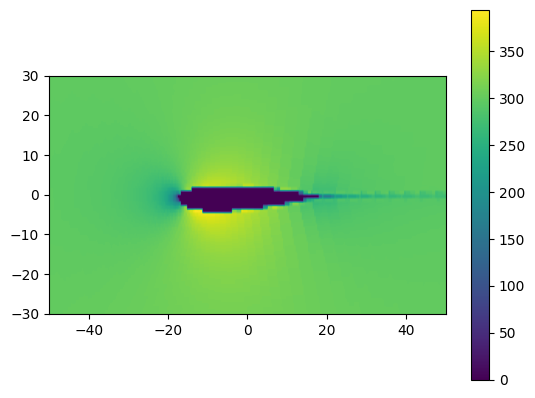

In [11]:
plt.imshow(df[1000,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.colorbar()

In [8]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([U_max,U_max,U_max, p_max,k_max, omega_max,nut_max]).reshape(1,1,1,7)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)


[[[[4.41323047e+03 4.41323047e+03 4.41323047e+03 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]


In [7]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [10]:
n=[3]
df1=df*1/normal
df_label1=df_label/normal
df1=df1[:,:,:,n]
df_label1=df_label1[:,:,:,n]

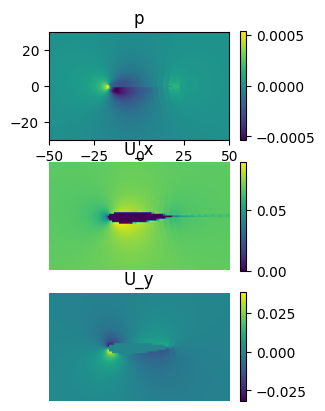

In [14]:
fig = plt.figure()

fig.add_subplot(3, 2, 1)
plt.imshow(df_label1[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label1[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label1[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [11]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

In [16]:
ylim[1]

30

20


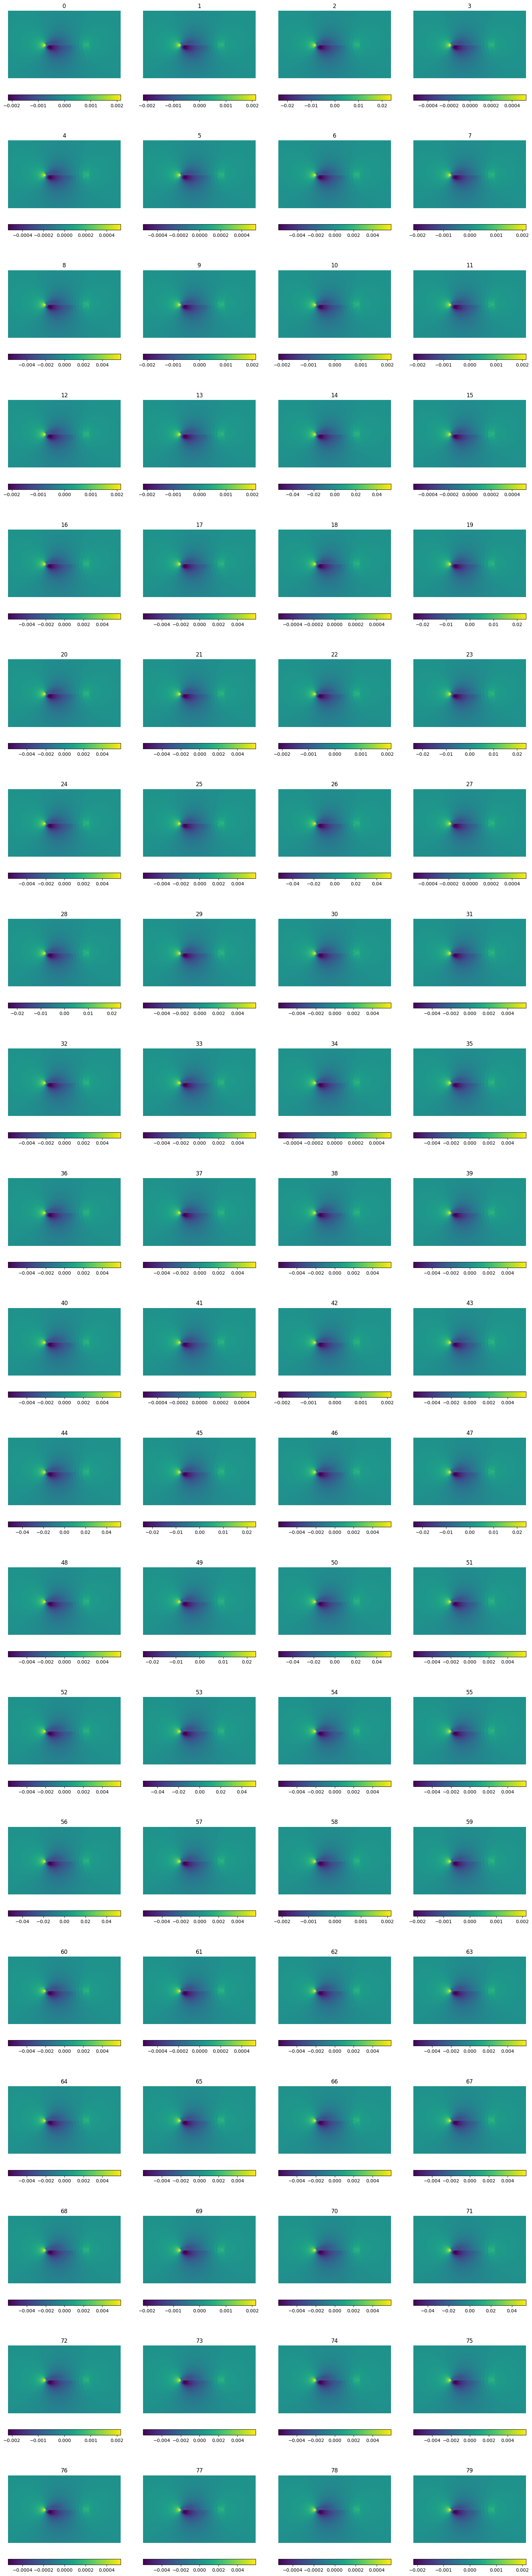

In [12]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [13]:
[a,b,c,d]=df1.shape
print(d)

1


In [15]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, d)))
model.add(layers.Conv2D(32,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(d,(4,16),(2,8), activation='linear', padding="same"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 33, 32, 16)        784       
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 8, 32)         18464     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 256)         1573120   
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 11, 8, 32)        1146912   
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 66, 256, 1)      

In [17]:
model.compile(optimizer='adam',
              loss='MSE')

In [18]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_23', 'training_24', 'training_25', 'training_26', 'training_27', 'training_28', 'training_29', 'training_30', 'training_31', 'training_32', 'training_33', 'training_34', 'training_35']
training_36


In [19]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [20]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 1.0563e-05
Epoch 1: loss improved from inf to 0.00001, saving model to training/training_36\vae_best_model_relu.epoch01-loss0.00001.w
61/61 [==============================] - 8s 120ms/step - loss: 1.0563e-05 - val_loss: 1.0119e-05
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 1.0527e-05
Epoch 2: loss improved from 0.00001 to 0.00001, saving model to training/training_36\vae_best_model_relu.epoch02-loss0.00001.w
61/61 [==============================] - 7s 118ms/step - loss: 1.0527e-05 - val_loss: 9.9165e-06
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 9.6020e-06
Epoch 3: loss improved from 0.00001 to 0.00001, saving model to training/training_36\vae_best_model_relu.epoch03-loss0.00001.w
61/61 [==============================] - 7s 118ms/step - loss: 9.6020e-06 - val_loss: 7.2762e-06
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 6.9424e-06
Epoch 4: los

61/61 [==============================] - ETA: 0s - loss: 1.6014e-07
Epoch 31: loss improved from 0.00000 to 0.00000, saving model to training/training_36\vae_best_model_relu.epoch31-loss0.00000.w
61/61 [==============================] - 7s 120ms/step - loss: 1.6014e-07 - val_loss: 1.7366e-07
Epoch 32/100
61/61 [==============================] - ETA: 0s - loss: 1.6649e-07
Epoch 32: loss did not improve from 0.00000
61/61 [==============================] - 7s 117ms/step - loss: 1.6649e-07 - val_loss: 1.4673e-07
Epoch 33/100
61/61 [==============================] - ETA: 0s - loss: 1.5178e-07
Epoch 33: loss improved from 0.00000 to 0.00000, saving model to training/training_36\vae_best_model_relu.epoch33-loss0.00000.w
61/61 [==============================] - 8s 124ms/step - loss: 1.5178e-07 - val_loss: 1.6677e-07
Epoch 34/100
61/61 [==============================] - ETA: 0s - loss: 1.5472e-07
Epoch 34: loss did not improve from 0.00000
61/61 [==============================] - 7s 121ms/step

61/61 [==============================] - 7s 115ms/step - loss: 1.1248e-07 - val_loss: 6.4805e-08
Epoch 64/100
61/61 [==============================] - ETA: 0s - loss: 9.5498e-08
Epoch 64: loss did not improve from 0.00000
61/61 [==============================] - 7s 115ms/step - loss: 9.5498e-08 - val_loss: 6.6029e-08
Epoch 65/100
61/61 [==============================] - ETA: 0s - loss: 8.7496e-08
Epoch 65: loss improved from 0.00000 to 0.00000, saving model to training/training_36\vae_best_model_relu.epoch65-loss0.00000.w
61/61 [==============================] - 7s 116ms/step - loss: 8.7496e-08 - val_loss: 5.5651e-08
Epoch 66/100
61/61 [==============================] - ETA: 0s - loss: 9.3573e-08
Epoch 66: loss did not improve from 0.00000
61/61 [==============================] - 7s 117ms/step - loss: 9.3573e-08 - val_loss: 6.4890e-08
Epoch 67/100
61/61 [==============================] - ETA: 0s - loss: 9.7909e-08
Epoch 67: loss did not improve from 0.00000
61/61 [=====================

61/61 [==============================] - ETA: 0s - loss: 7.1202e-08
Epoch 98: loss did not improve from 0.00000
61/61 [==============================] - 7s 115ms/step - loss: 7.1202e-08 - val_loss: 4.3819e-08
Epoch 99/100
61/61 [==============================] - ETA: 0s - loss: 8.3054e-08
Epoch 99: loss did not improve from 0.00000
61/61 [==============================] - 7s 115ms/step - loss: 8.3054e-08 - val_loss: 5.6646e-08
Epoch 100/100
61/61 [==============================] - ETA: 0s - loss: 9.4521e-08
Epoch 100: loss did not improve from 0.00000
61/61 [==============================] - 7s 115ms/step - loss: 9.4521e-08 - val_loss: 3.9137e-08


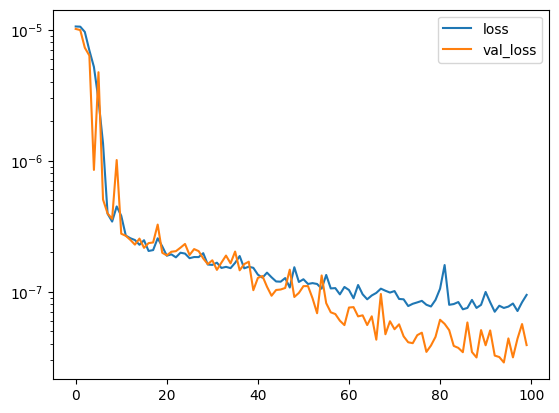

In [21]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [22]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

93
vae_best_model_relu.epoch93-loss0.00000.w


In [23]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_36/vae_best_model_relu.epoch93-loss0.00000.w


In [24]:
test=model.predict(test_data)

11/11 [==============================] - 1s 35ms/step


In [26]:
print(label_test.shape[0])
n=0
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.067151695
min: -0.066673875


In [33]:
test1=test*normal[:,:,:,3]
label_test1=label_test*normal[:,:,:,3]

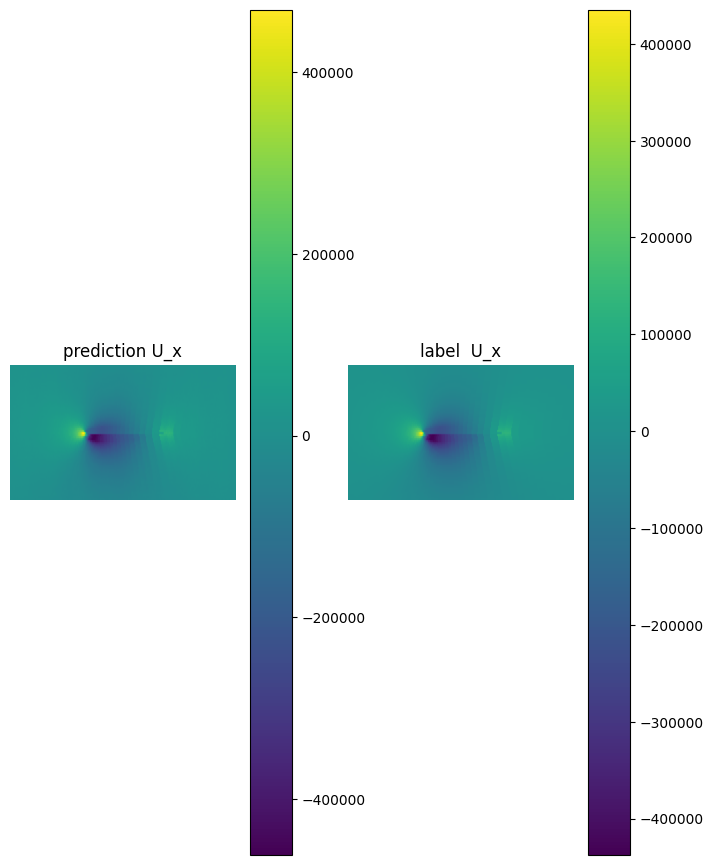

In [34]:
n=40
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test1[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test1[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

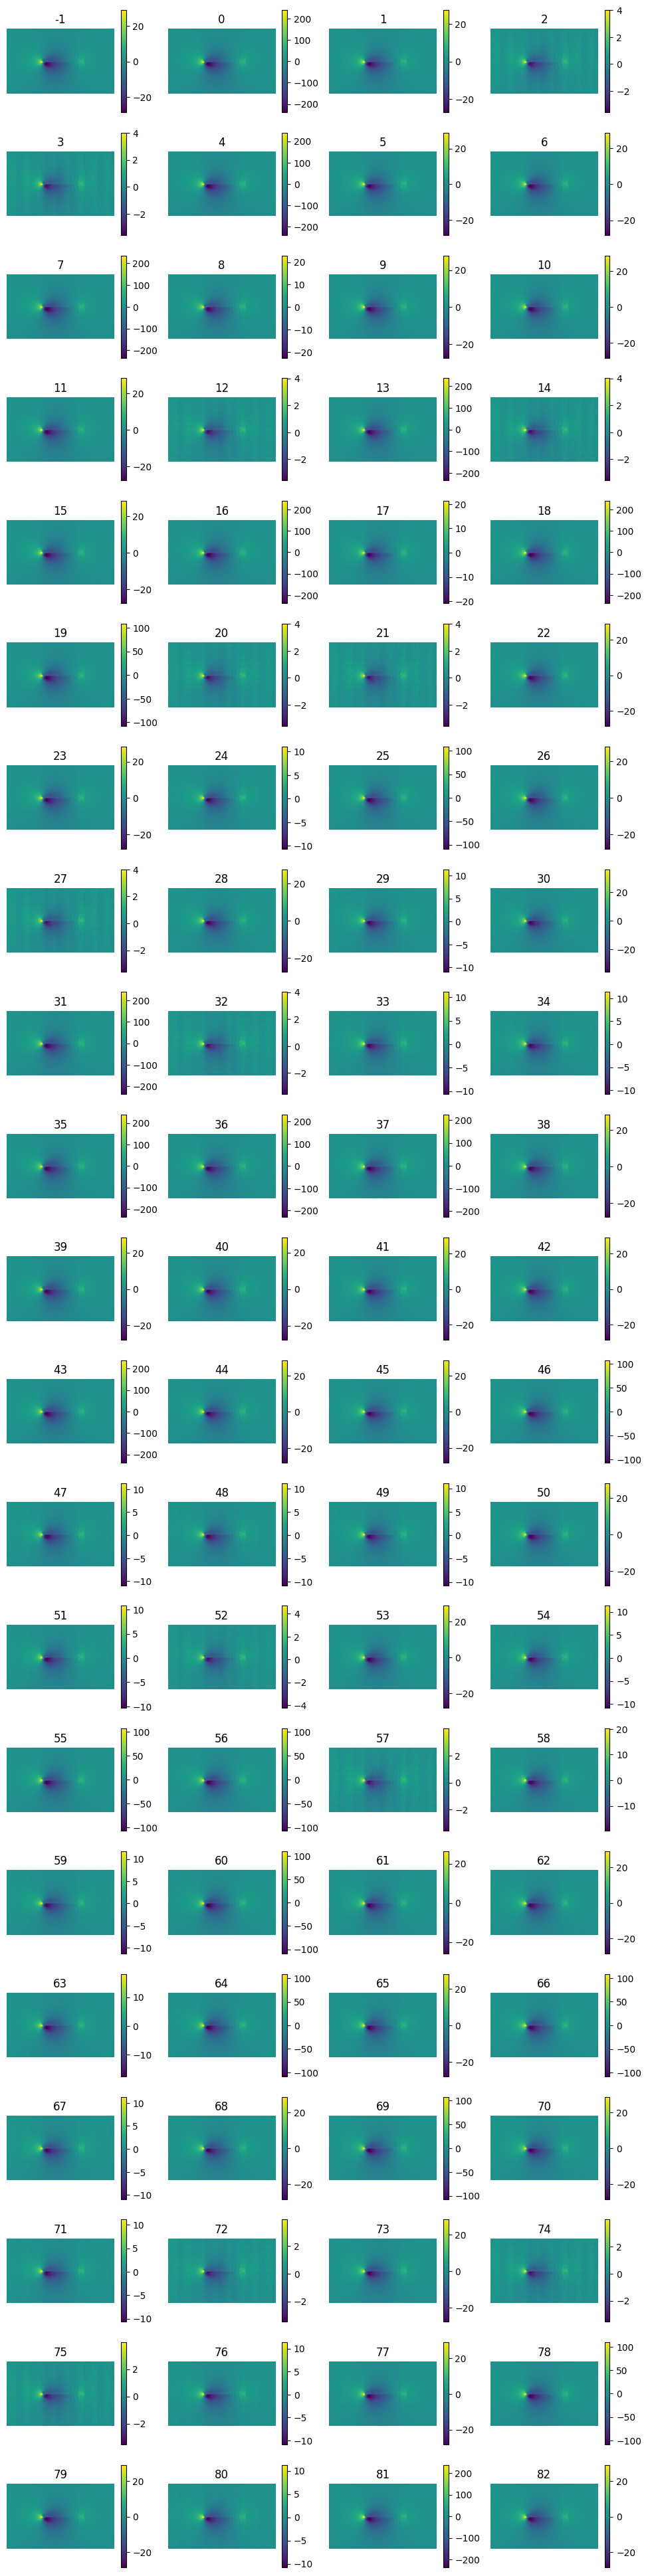

In [31]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test1[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()
    

In [57]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:0.004268981377960514
0.1615901839459936
0.002357455493213041
average ssim: 0.1640604946376105
average mse: 0.002592235416306115


In [35]:
print('model saved to: '+'cfdnetplus_models/'+modelid)
model.save('cfdnetplus_models/'+modelid)

model saved to: cfdnetplus_models/model_mse_adam_p


INFO:tensorflow:Assets written to: cfdnetplus_models/model_mse_adam_p\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_mse_adam_p\assets
